# Comparing Pre-Calculated Vs On-The-Fly-Calculated Pairings Performance

## Sample combinations for each combination size

In [17]:
%matplotlib inline

from pymongo import MongoClient
import random
import time

URL = None
DATABASE = "yummly"
COMBINATIONS_COLLECTION = "combinations1k"
RECIPES_COLLECTION = "recipes1k"
SAMPLE_SIZE = 1000
RAND_SEED = 0
RMAX = 5

client = MongoClient(URL) if URL else MongoClient()
db = client[DATABASE]
combos_coll = db[COMBINATIONS_COLLECTION]

random.seed(RAND_SEED)
samples = {}
for r in range(1, RMAX + 1):
    count = combos_coll.count({"r": r})
    to_sample = random.sample(range(0,count), SAMPLE_SIZE)
    to_sample.sort()
    
    cursor = combos_coll.find({"r": r})
    position = 0
    samples[r] = []
    for index in to_sample:
        while position <= index:
            record = cursor.next()
            position += 1
        samples[r].append(record)

print(samples)

{1: [{'or_count': 1, 'ingredients': ['Stokes Purple'], 'and_count': 1, 'r': 1, '_id': 'Stokes Purple'}, {'or_count': 2, 'ingredients': ['arrowroot starch'], 'and_count': 2, 'r': 1, '_id': 'arrowroot starch'}, {'or_count': 76, 'ingredients': ['black pepper'], 'and_count': 76, 'r': 1, '_id': 'black pepper'}, {'or_count': 36, 'ingredients': ['garlic powder'], 'and_count': 36, 'r': 1, '_id': 'garlic powder'}, {'or_count': 6, 'ingredients': ['onion powder'], 'and_count': 6, 'r': 1, '_id': 'onion powder'}, {'or_count': 2, 'ingredients': ['english cucumber'], 'and_count': 2, 'r': 1, '_id': 'english cucumber'}, {'or_count': 8, 'ingredients': ['fresh dill'], 'and_count': 8, 'r': 1, '_id': 'fresh dill'}, {'or_count': 71, 'ingredients': ['garlic'], 'and_count': 71, 'r': 1, '_id': 'garlic'}, {'or_count': 45, 'ingredients': ['ground black pepper'], 'and_count': 45, 'r': 1, '_id': 'ground black pepper'}, {'or_count': 2, 'ingredients': ['cornbread mix'], 'and_count': 2, 'r': 1, '_id': 'cornbread mix'

## Perform Pre-Calculated Queries

In [18]:
precalc_times = {}

for r in samples:
    combos = samples[r]
    precalc_times[r] = []
    for combo in combos:
        ingredients = combo["ingredients"]
        pipeline = [
            {
                "$match": {
                    "r": r,
                    "ingredients": {
                        "$all": ingredients
                    }
                }
            },
            {
                "$project": {
                    "_id": 0,
                    "score": {
                        "$divide": ["$and_count", "$or_count"]
                    },
                    "name": {
                        "$arrayElemAt": [
                            {"$setDifference": ["$ingredients", ingredients]},
                            0
                        ]
                    }
                }
            },
            {
                "$sort": {
                    "score": -1
                }
            }
        ]
        
        start = time.time()
        result = list(db.combinations1k.aggregate(pipeline))
        end = time.time()
        precalc_times[r].append(end - start)

print(precalc_times)

{1: [0.0010027885437011719, 0.00075531005859375, 0.0007390975952148438, 0.0015761852264404297, 0.000881195068359375, 0.0007491111755371094, 0.0007476806640625, 0.0007426738739013672, 0.0007333755493164062, 0.0007250308990478516, 0.0009932518005371094, 0.0011241436004638672, 0.0008521080017089844, 0.0006499290466308594, 0.0005207061767578125, 0.0007221698760986328, 0.0006461143493652344, 0.0004889965057373047, 0.0005512237548828125, 0.0005199909210205078, 0.0005617141723632812, 0.0006105899810791016, 0.0006747245788574219, 0.0006425380706787109, 0.0008089542388916016, 0.000850677490234375, 0.001032114028930664, 0.0010023117065429688, 0.0005714893341064453, 0.0005064010620117188, 0.0005390644073486328, 0.0005655288696289062, 0.0005776882171630859, 0.0005064010620117188, 0.0006234645843505859, 0.0007174015045166016, 0.0008473396301269531, 0.0010411739349365234, 0.0009768009185791016, 0.0009555816650390625, 0.00077056884765625, 0.0006628036499023438, 0.0006735324859619141, 0.00065779685974

## Perform OTF-Calculated Queries

In [19]:
otfcalc_times = {}

for r in sorted(samples, reverse=True):
    combos = samples[r]
    otfcalc_times[r] = []
    for combo in combos:
        #get pairing candidates
        ingredients = combo["ingredients"]
        pipeline = [
            {
                "$match": {
                    "ingredients": {
                        "$all": ingredients
                    }
                }
            },
            {
                "$project": {
                    "ingredients": {
                        "$setDifference": ["$ingredients", ingredients]
                    }
                }
            },
            {
                "$unwind": "$ingredients"
            },
            {
                "$group": {
                    "_id": None,
                    "pairings": {
                        "$addToSet": "$ingredients"
                    }
                }
            },
            {
                "$project": {
                    "_id": 0,
                    "pairings": 1
                }
            }
        ]
        
        start = time.time()
        candidates = db.recipes1k.aggregate(pipeline).next()["pairings"]

        #get ranked pairings
        pairings = []
        for candidate in candidates:
            combination = list(ingredients) + [candidate]
            combination.sort()

            and_count = db.recipes1k.find({
                "ingredients": {
                    "$all": combination
                }
            }).count()

            or_count = db.recipes1k.find({
                "ingredients": {
                    "$in": combination
                }
            }).count()

            pairings.append({
                "name": candidate,
                "score": and_count / float(or_count)
            })

        end = time.time()
        otfcalc_times[r].append(end - start)

print(otfcalc_times)

{1: [0.005059480667114258, 0.019543886184692383, 0.5596647262573242, 0.2690896987915039, 0.05727243423461914, 0.0236055850982666, 0.07039999961853027, 0.6324508190155029, 0.2714717388153076, 0.004781484603881836, 0.7830126285552979, 0.01085805892944336, 0.54050612449646, 0.20125865936279297, 0.5927925109863281, 0.48603391647338867, 0.18405604362487793, 0.3793656826019287, 0.12795090675354004, 0.005854129791259766, 0.32053422927856445, 0.024600505828857422, 0.025008678436279297, 0.10852384567260742, 0.25901198387145996, 0.14476609230041504, 0.01033329963684082, 0.010962724685668945, 0.39977121353149414, 0.07606935501098633, 0.03148031234741211, 0.1408233642578125, 0.010181427001953125, 0.04632449150085449, 0.016865015029907227, 0.016956806182861328, 0.03966808319091797, 0.5795137882232666, 1.0049679279327393, 0.04376101493835449, 0.2869582176208496, 0.03669476509094238, 0.00904083251953125, 0.007375478744506836, 0.007876157760620117, 0.015223503112792969, 0.11441922187805176, 0.01535820

## Compare Average Query Times

[0.0006785385608673095, 0.0008872292041778565, 0.0029918005466461183, 0.007273334980010987, 0.02204843020439148]


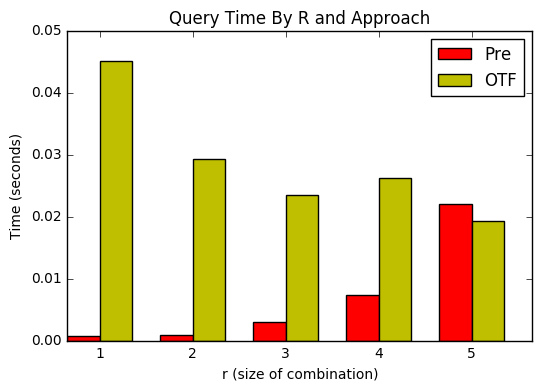

In [20]:
# print("Pre-Calculated")
# for r in sorted(precalc_times.keys()):
#     times = precalc_times[r]
#     mean = sum(times) / float(len(times))
#     print("{r}: {mean}".format(r=r, mean=mean))
    
# print("On-The-Fly-Calculated")
# for r in sorted(otfcalc_times.keys()):
#     times = otfcalc_times[r]
#     mean = sum(times) / float(len(times))
#     print("{r}: {mean}".format(r=r, mean=mean))
    
import numpy as np
import matplotlib.pyplot as plt

# http://matplotlib.org/examples/api/barchart_demo.html

N = len(precalc_times.keys())
preMeans = [sum(precalc_times[r]) / float(len(precalc_times[r])) for r in sorted(precalc_times.keys())]
print(preMeans)
#calculate standard deviation
preStd = None

ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, preMeans, width, color='r')

otfMeans = [sum(otfcalc_times[r]) / float(len(otfcalc_times[r])) for r in sorted(otfcalc_times.keys())]
otfStd = None
rects2 = ax.bar(ind + width, otfMeans, width, color='y')

ax.set_ylabel('Time (seconds)')
ax.set_xlabel('r (size of combination)')
ax.set_title('Query Time By R and Approach')
ax.set_xticks(ind + width)
ax.set_xticklabels(('1', '2', '3', '4', '5'))

ax.legend((rects1[0], rects2[0]), ('Pre', 'OTF'))

plt.show()
        